# Notebook model

In [1]:
# Import des librairies
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# preprocessing 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Rescaling

# hyperparameters
from functools import partial 

# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

# warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-05-04 17:15:05.829866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 17:15:05.856860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 17:15:05.857831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 17:15:06.391948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import des données
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv") # données sans target, non labelisées
sample = df.sample(n=100, random_state=42)

In [3]:
sample.shape

(100, 785)

In [4]:
X_s = sample.drop(["label"], axis = 1)
X_s = X_s.values.reshape(-1, 28, 28, 1)

In [5]:
X_s.shape

(100, 28, 28, 1)

In [6]:
df.shape

(42000, 785)

In [7]:
df_test.shape

(28000, 784)

In [8]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
len(df.label.unique())

10

## preprocessing

In [10]:
# séparer les features de la target
X = df.drop(["label"], axis = 1)
y = df["label"]

# train test split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [11]:
X_train.shape

(33600, 784)

In [12]:
X_valid.shape

(8400, 784)

In [13]:
X_train_arr = X_train.values.reshape(33600, 28, 28, 1)
X_valid_arr = X_valid.values.reshape(8400, 28, 28, 1)

In [14]:
# preprocessing
X_train = Rescaling(scale=1 / 255)(X_train)
X_valid = Rescaling(scale=1 / 255)(X_valid)

2023-05-04 17:15:08.719954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:15:08.720247: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
input_shape = (28, 28, 1)

## CNN model

In [16]:
# model CNN
DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", activation="relu", 
                        kernel_initializer="he_normal")

model = Sequential([
    DefaultConv2D(filters=8, kernel_size=5, input_shape=(28, 28, 1)),
    MaxPool2D(),
    DefaultConv2D(filters=16),
    MaxPool2D(),
    DefaultConv2D(filters=32),
    MaxPool2D(),
    DefaultConv2D(filters=64),
    Flatten(),
    Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    Dense(units=32, activation="relu", kernel_initializer="he_normal"),
    Dense(units=10, activation="softmax")
])


model.compile(optimizer = Adam(learning_rate=0.01),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit(
    X_train_arr, y_train,
    validation_data=(X_valid_arr, y_valid),
    batch_size=1024,
    epochs=30,
    verbose=0,
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0

Text(0.5, 1.0, 'Accuracy: 0.9540')

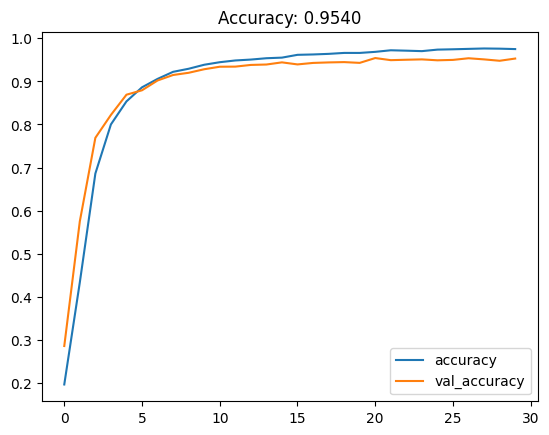

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.title("Accuracy: {:0.4f}".format(history_df['val_accuracy'].max()))

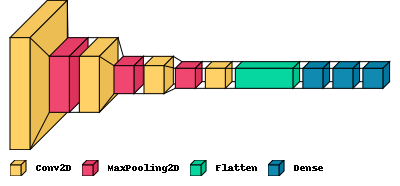

In [20]:
import visualkeras

visualkeras.layered_view(model,legend=True).show() # display using your system viewer
visualkeras.layered_view(model,legend=True, to_file='output.png') 

In [32]:
model.save('modeloo.h5')

## Data augmentation

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# model CNN
DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", activation="relu", 
                        kernel_initializer="he_normal")

model = Sequential([
    DefaultConv2D(filters=8, kernel_size=5, input_shape=(28, 28, 1)),
    MaxPool2D(),
    DefaultConv2D(filters=16),
    MaxPool2D(),
    DefaultConv2D(filters=32),
    MaxPool2D(),
    DefaultConv2D(filters=64),
    Flatten(),
    Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    Dense(units=32, activation="relu", kernel_initializer="he_normal"),
    Dense(units=10, activation="softmax")
])


model.compile(optimizer = Adam(learning_rate=0.05),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])


datagen = ImageDataGenerator(
    rotation_range=20,      # randomly rotate images by up to 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by up to 10%
    height_shift_range=0.1, # randomly shift images vertically by up to 10%
    zoom_range=0.1,         # randomly zoom images by up to 10%
    horizontal_flip=True,   # randomly flip images horizontally
    vertical_flip=False,    # don't flip images vertically
)


history = model.fit_generator(
    datagen.flow(X_train_arr, y_train, batch_size=1024),
    validation_data=(X_valid_arr, y_valid),
    steps_per_epoch=len(X_train_arr) // 1024,
    epochs=30,
    verbose=0,
)

2023-05-04 14:36:33.368255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy: 0.1095')

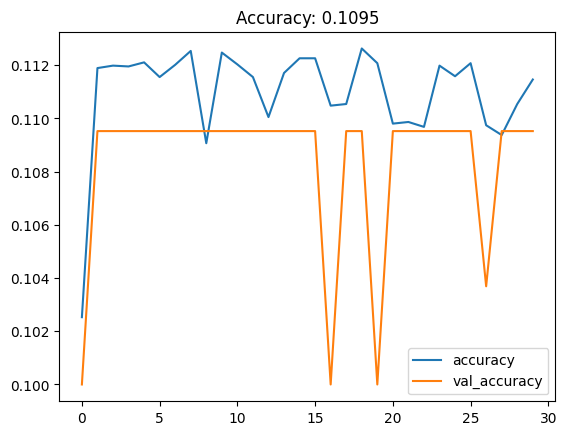

In [38]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.title("Accuracy: {:0.4f}".format(history_df['val_accuracy'].max()))

In [36]:
model.save('model_aug.h5')

## Transfer Learning

In [14]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(28, 28, 1))

# Add your own top (fully connected) layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

# Create your own model by combining the base model with your top layers
model = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with your own data
history_3 = model.fit(
    X_train_resized, y_train,
    validation_data=(X_valid_resized, y_valid),
    batch_size=1024,
    epochs=30,
    verbose=0,
)

ValueError: The input must have 3 channels; Received `input_shape=(28, 28, 1)`

In [ ]:
history_df3 = pd.DataFrame(history_3.history_3)
history_df3.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.title("Accuracy: {:0.4f}".format(history_df3['val_accuracy'].max()))

## Export models

## Export data

In [15]:
sample = sample.to_csv("data/sample.csv", index=False)